In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

# Global

Directly using local is sufficient

In [3]:
stack_fixed = 'LM30new'
# stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [4]:
# warp_setting = 20
warp_setting = 16
# Adding surr is essential.

In [5]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                                  None
transform_type                                  affine
terminate_thresh                                 1e-05
grad_computation_sample_number                  100000
grid_search_sample_number                         1000
std_tx_um                                         2000
std_ty_um                                         2000
std_tz_um                                         2000
std_theta_xy_degree                                 30
surround_weight                                inverse
regularization_weight                              NaN
comment                           global reg with surr
max_iter_num                                       NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [7]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [8]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_10N_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volum

rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Pn_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volum

rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volum

Volume shape: (356, 427, 375)


In [9]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L_surround_200.bp
Score volume for 10N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R_surround_200.bp
Score volume for 10N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_10N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N_surround_200.bp
Score volume for 12N_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_12N_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R_surround_200.bp
Score volume for 3N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_3N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L_surround_200.bp
Score volume for 4N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R_surround_200.bp
Score volume for 4N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_4N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L.bp
Score volume for 5N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L_surround_200.bp
Score volume for 5N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R.bp
Score volume for 5N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R_surround_200.bp
Score volume for 5N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_5N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L_surround_200.bp
Score volume for 6N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R_surround_200.bp
Score volume for 6N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_6N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L.bp
Score volume for 7N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L_surround_200.bp
Score volume for 7N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R.bp
Score volume for 7N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R_surround_200.bp
Score volume for 7N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L.bp
Score volume for 7n_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L_surround_200.bp
Score volume for 7n_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R.bp
Score volume for 7n_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R_surround_200.bp
Score volume for 7n_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_7n_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP_surround_200.bp
Score volume for AP_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_AP_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L.bp
Score volume for Amb_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L_surround_200.bp
Score volume for Amb_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R_surround_200.bp
Score volume for Amb_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Amb_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L_surround_200.bp
Score volume for DC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R_surround_200.bp
Score volume for DC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_DC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC_surround_200.bp
Score volume for IC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_IC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L_surround_200.bp
Score volume for LC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R_surround_200.bp
Score volume for LC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L.bp
Score volume for LRt_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L_surround_200.bp
Score volume for LRt_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R.bp
Score volume for LRt_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R_surround_200.bp
Score volume for LRt_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_LRt_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L_surround_200.bp
Score volume for PBG_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R_surround_200.bp
Score volume for PBG_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_PBG_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L_surround_200.bp
Score volume for Pn_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R_surround_200.bp
Score volume for Pn_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Pn_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R_surround_200.bp
Score volume for RMC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RMC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg_surround_200.bp
Score volume for RtTg_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_RtTg_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC_surround_200.bp
Score volume for SC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L_surround_200.bp
Score volume for SNC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R_surround_200.bp
Score volume for SNC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R_surround_200.bp
Score volume for SNR_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_SNR_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L.bp
Score volume for Sp5C_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp
Score volume for Sp5C_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R.bp
Score volume for Sp5C_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp
Score volume for Sp5C_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L.bp
Score volume for Sp5I_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp
Score volume for Sp5I_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R.bp
Score volume for Sp5I_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp
Score volume for Sp5I_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp
Score volume for Sp5O_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R.bp
Score volume for Sp5O_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp
Score volume for Sp5O_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L_surround_200.bp
Score volume for Tz_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R_surround_200.bp
Score volume for Tz_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_Tz_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L_surround_200.bp
Score volume for VCA_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R_surround_200.bp
Score volume for VCA_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCA_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L_surround_200.bp
Score volume for VCP_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R_surround_200.bp
Score volume for VCP_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VCP_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L_surround_200.bp
Score volume for VLL_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" "/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R_surround_200.bp"
(186, 143, 188)


File does not exist: /shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R_surround_200.bp
Score volume for VLL_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volumes/LM30new_down32_annotationAsScoreVolume_VLL_R_surround_200.bp'
Volume shape: (186, 143, 188)


In [10]:
structure_subset = all_known_structures_sided

In [11]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [12]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [13]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [14]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [15]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [16]:
label_weights_m

{7: 1.0,
 8: 0.08578068878090006,
 59: 1.0,
 60: 0.15379052789032086,
 71: 1.0,
 72: 0.40870655618253604}

In [17]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [18]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['SNR_L']])

centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [  68.07515537  115.35417473   62.30829339]


In [19]:
aligner.set_label_weights(label_weights=label_weights_m)

In [20]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [21]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/shared/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [22]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.096507 seconds
load gradient 2: 0.091137 seconds
load gradient 3: 0.091305 seconds
load gradient 4: 0.092310 seconds
load gradient 5: 0.093099 seconds
load gradient 6: 0.096104 seconds
overall: 0.560941 seconds


In [23]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Error computing score/gradient for 7: Image gradient at all valid voxel is zero.
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 10.00
step: 0.47 seconds
current score: -0.373364
new_T: [-10. -10. 10.]
det: 1.10

iteration 1
Error computing score/gradient for 7: Image gradient at all valid voxel is zero.
in T: -10.00 -10.00 10.00, out T: -1.00 -1.51 0.37
step: 0.47 seconds
current score: -0.391712
new_T: [-1.00367882 -1.50965438  0.37082192]
det: 1.04

iteration 2
in T: -1.00 -1.51 0.37, out T: 1.50 -3.31 1.31
step: 0.47 seconds
current score: -0.367238
new_T: [ 1.50158909 -3.30672325  1.31015371]
det: 1.19

iteration 3
in T: 1.50 -3.31 1.31, out T: 0.71 -1.40 -4.12
step: 0.47 seconds
current score: -0.368584
new_T: [ 0.7148401  -1.40414388 -4.11534896]
det: 1.08

iteration 4
in T: 0.71 -1.40 -4.12, out T: 1.45 -4.64 2.70
step: 0.47 seconds
current score: -0.370203
new_T: [ 1.45251064 -4.64385062  2.70448921]
det: 1.21

iteration 5
in T: 1.45 -4.64 2.70, out T: 1.32 -0.76 -1.45

in T: 0.97 -2.61 -0.86, out T: 0.86 -2.98 -0.39
step: 0.47 seconds
current score: -0.367655
new_T: [ 0.86391095 -2.97625106 -0.39316051]
det: 1.31

iteration 52
in T: 0.86 -2.98 -0.39, out T: 0.43 -2.98 -0.56
step: 0.47 seconds
current score: -0.367714
new_T: [ 0.43430857 -2.97680117 -0.56043099]
det: 1.30

iteration 53
in T: 0.43 -2.98 -0.56, out T: 1.41 -2.90 -0.53
step: 0.47 seconds
current score: -0.367523
new_T: [ 1.41207239 -2.90455725 -0.52801601]
det: 1.31

iteration 54
in T: 1.41 -2.90 -0.53, out T: 0.94 -2.97 -0.60
step: 0.47 seconds
current score: -0.367347
new_T: [ 0.93907787 -2.9686878  -0.60269471]
det: 1.30

iteration 55
in T: 0.94 -2.97 -0.60, out T: 0.88 -2.85 -0.57
step: 0.47 seconds
current score: -0.367580
new_T: [ 0.87971928 -2.84761253 -0.57313049]
det: 1.31

iteration 56
in T: 0.88 -2.85 -0.57, out T: 0.88 -2.63 -0.61
step: 0.47 seconds
current score: -0.367616
new_T: [ 0.88468854 -2.62897297 -0.60790352]
det: 1.31

iteration 57
in T: 0.88 -2.63 -0.61, out T: 0.7

in T: 1.00 -2.94 -0.43, out T: 1.05 -3.09 -0.45
step: 0.48 seconds
current score: -0.369164
new_T: [ 1.04568833 -3.09265388 -0.45418179]
det: 1.40

iteration 103
in T: 1.05 -3.09 -0.45, out T: 1.00 -2.99 -0.46
step: 0.47 seconds
current score: -0.369521
new_T: [ 1.00402312 -2.98978446 -0.46122717]
det: 1.40

iteration 104
in T: 1.00 -2.99 -0.46, out T: 1.17 -2.98 -0.60
step: 0.47 seconds
current score: -0.369677
new_T: [ 1.16813197 -2.97904623 -0.59876562]
det: 1.41

iteration 105
in T: 1.17 -2.98 -0.60, out T: 1.20 -2.86 -0.43
step: 0.47 seconds
current score: -0.369520
new_T: [ 1.20444995 -2.86383826 -0.43348836]
det: 1.41

iteration 106
in T: 1.20 -2.86 -0.43, out T: 1.01 -2.98 -0.69
step: 0.47 seconds
current score: -0.369562
new_T: [ 1.00956699 -2.98144724 -0.69253185]
det: 1.41

iteration 107
in T: 1.01 -2.98 -0.69, out T: 0.75 -2.96 -0.34
step: 0.47 seconds
current score: -0.369460
new_T: [ 0.75387922 -2.95649899 -0.33796445]
det: 1.42

iteration 108
in T: 0.75 -2.96 -0.34, out 

in T: 0.56 -3.74 -1.00, out T: 0.76 -3.23 -0.96
step: 0.48 seconds
current score: -0.372202
new_T: [ 0.76216104 -3.23121637 -0.96151357]
det: 1.52

iteration 154
in T: 0.76 -3.23 -0.96, out T: 0.86 -3.28 -1.01
step: 0.47 seconds
current score: -0.371997
new_T: [ 0.86034954 -3.27976668 -1.01244124]
det: 1.52

iteration 155
in T: 0.86 -3.28 -1.01, out T: 0.98 -3.46 -0.79
step: 0.48 seconds
current score: -0.371891
new_T: [ 0.97860591 -3.45538365 -0.79407423]
det: 1.54

iteration 156
in T: 0.98 -3.46 -0.79, out T: 1.12 -3.54 -0.83
step: 0.47 seconds
current score: -0.372276
new_T: [ 1.12047831 -3.54430724 -0.8342754 ]
det: 1.54

iteration 157
in T: 1.12 -3.54 -0.83, out T: 0.89 -3.50 -0.94
step: 0.47 seconds
current score: -0.372342
new_T: [ 0.89464867 -3.4977417  -0.94210508]
det: 1.53

iteration 158
in T: 0.89 -3.50 -0.94, out T: 1.08 -3.62 -0.74
step: 0.47 seconds
current score: -0.372106
new_T: [ 1.07563997 -3.6204047  -0.74354684]
det: 1.54

iteration 159
in T: 1.08 -3.62 -0.74, out 

in T: 0.48 -3.11 -0.98, out T: 0.62 -2.99 -0.92
step: 0.48 seconds
current score: -0.374509
new_T: [ 0.6179593  -2.9939538  -0.92210005]
det: 1.64

iteration 205
in T: 0.62 -2.99 -0.92, out T: 0.47 -3.26 -0.65
step: 0.48 seconds
current score: -0.374825
new_T: [ 0.472872   -3.25914526 -0.64605241]
det: 1.64

iteration 206
in T: 0.47 -3.26 -0.65, out T: 0.79 -2.83 -1.15
step: 0.47 seconds
current score: -0.374748
new_T: [ 0.7932798  -2.82694261 -1.14984171]
det: 1.64

iteration 207
in T: 0.79 -2.83 -1.15, out T: 0.70 -3.09 -0.86
step: 0.48 seconds
current score: -0.374916
new_T: [ 0.69573351 -3.08844478 -0.86437529]
det: 1.64

iteration 208
in T: 0.70 -3.09 -0.86, out T: 0.71 -3.13 -0.93
step: 0.48 seconds
current score: -0.374896
new_T: [ 0.71445191 -3.12964625 -0.92748631]
det: 1.64

iteration 209
in T: 0.71 -3.13 -0.93, out T: 0.19 -3.29 -0.76
step: 0.47 seconds
current score: -0.374556
new_T: [ 0.19017981 -3.28561411 -0.75683401]
det: 1.64

iteration 210
in T: 0.19 -3.29 -0.76, out 

in T: 0.04 -3.37 -0.98, out T: 0.25 -3.24 -0.83
step: 0.47 seconds
current score: -0.376245
new_T: [ 0.2465631  -3.24042041 -0.8274372 ]
det: 1.70

iteration 256
in T: 0.25 -3.24 -0.83, out T: 0.42 -3.11 -0.94
step: 0.47 seconds
current score: -0.376083
new_T: [ 0.41964919 -3.11048844 -0.9388524 ]
det: 1.70

iteration 257
in T: 0.42 -3.11 -0.94, out T: 0.66 -3.27 -0.83
step: 0.47 seconds
current score: -0.376264
new_T: [ 0.65620926 -3.26591396 -0.83035289]
det: 1.70

iteration 258
in T: 0.66 -3.27 -0.83, out T: 0.67 -3.09 -1.04
step: 0.47 seconds
current score: -0.376190
new_T: [ 0.67357724 -3.0921472  -1.03610394]
det: 1.70

iteration 259
in T: 0.67 -3.09 -1.04, out T: 0.65 -3.32 -0.76
step: 0.48 seconds
current score: -0.376246
new_T: [ 0.6505892  -3.32313602 -0.76153198]
det: 1.71

iteration 260
in T: 0.65 -3.32 -0.76, out T: 0.89 -3.17 -1.05
step: 0.47 seconds
current score: -0.376352
new_T: [ 0.88572566 -3.17213358 -1.0505372 ]
det: 1.70

iteration 261
in T: 0.89 -3.17 -1.05, out 

in T: -0.06 -3.41 -0.92, out T: 0.20 -3.14 -0.89
step: 0.48 seconds
current score: -0.377326
new_T: [ 0.19981792 -3.13536415 -0.88843613]
det: 1.77

iteration 307
in T: 0.20 -3.14 -0.89, out T: -0.05 -3.37 -1.02
step: 0.47 seconds
current score: -0.377463
new_T: [-0.04631831 -3.37150845 -1.01502117]
det: 1.76

iteration 308
in T: -0.05 -3.37 -1.02, out T: -0.10 -3.14 -0.87
step: 0.47 seconds
current score: -0.377320
new_T: [-0.10211016 -3.13671719 -0.87384006]
det: 1.76

iteration 309
in T: -0.10 -3.14 -0.87, out T: -0.17 -3.15 -0.79
step: 0.47 seconds
current score: -0.377118
new_T: [-0.16532078 -3.14544967 -0.79064743]
det: 1.76

iteration 310
in T: -0.17 -3.15 -0.79, out T: -0.19 -3.01 -0.84
step: 0.47 seconds
current score: -0.377436
new_T: [-0.19312301 -3.01134732 -0.83722959]
det: 1.77

iteration 311
in T: -0.19 -3.01 -0.84, out T: -0.11 -3.21 -0.71
step: 0.47 seconds
current score: -0.377118
new_T: [-0.11221112 -3.20777315 -0.70956961]
det: 1.76

iteration 312
in T: -0.11 -3.21 

in T: 0.42 -3.12 -1.10, out T: 0.05 -3.48 -0.86
step: 0.47 seconds
current score: -0.377946
new_T: [ 0.04905689 -3.47666984 -0.85792485]
det: 1.78

iteration 358
in T: 0.05 -3.48 -0.86, out T: 0.37 -3.43 -0.94
step: 0.47 seconds
current score: -0.377960
new_T: [ 0.37249539 -3.4330869  -0.94395391]
det: 1.78

iteration 359
in T: 0.37 -3.43 -0.94, out T: 0.30 -3.39 -0.96
step: 0.48 seconds
current score: -0.378033
new_T: [ 0.29702948 -3.38706108 -0.95806279]
det: 1.78

iteration 360
in T: 0.30 -3.39 -0.96, out T: -0.14 -3.58 -0.80
step: 0.47 seconds
current score: -0.378055
new_T: [-0.14054402 -3.58047535 -0.79514321]
det: 1.78

iteration 361
in T: -0.14 -3.58 -0.80, out T: 0.47 -3.26 -0.72
step: 0.47 seconds
current score: -0.377923
new_T: [ 0.47428766 -3.25676555 -0.71510911]
det: 1.78

iteration 362
in T: 0.47 -3.26 -0.72, out T: 0.09 -3.58 -0.83
step: 0.47 seconds
current score: -0.377943
new_T: [ 0.0873763  -3.58279559 -0.83403324]
det: 1.78

iteration 363
in T: 0.09 -3.58 -0.83, ou

in T: -0.41 -2.98 -1.13, out T: -0.61 -3.19 -0.95
step: 0.47 seconds
current score: -0.379505
new_T: [-0.61099132 -3.18624106 -0.94614332]
det: 1.83

iteration 409
in T: -0.61 -3.19 -0.95, out T: -0.50 -2.97 -0.90
step: 0.47 seconds
current score: -0.379593
new_T: [-0.4972513  -2.96935369 -0.90025857]
det: 1.83

iteration 410
in T: -0.50 -2.97 -0.90, out T: -0.67 -3.05 -0.96
step: 0.47 seconds
current score: -0.379687
new_T: [-0.66677483 -3.05092488 -0.95739971]
det: 1.83

iteration 411
in T: -0.67 -3.05 -0.96, out T: -0.50 -2.89 -0.93
step: 0.47 seconds
current score: -0.379638
new_T: [-0.50026215 -2.88902823 -0.93095462]
det: 1.83

iteration 412
in T: -0.50 -2.89 -0.93, out T: -0.75 -3.10 -0.75
step: 0.47 seconds
current score: -0.379813
new_T: [-0.74669768 -3.09851512 -0.74973407]
det: 1.83

iteration 413
in T: -0.75 -3.10 -0.75, out T: -0.44 -2.90 -0.77
step: 0.47 seconds
current score: -0.379910
new_T: [-0.44215689 -2.8982275  -0.76980895]
det: 1.84

iteration 414
in T: -0.44 -2.9

in T: -1.04 -2.79 -0.76, out T: -1.01 -2.78 -0.82
step: 0.47 seconds
current score: -0.381591
new_T: [-1.00707803 -2.77758717 -0.82284331]
det: 1.88

iteration 459
in T: -1.01 -2.78 -0.82, out T: -1.29 -2.86 -0.88
step: 0.47 seconds
current score: -0.381634
new_T: [-1.28770149 -2.85584417 -0.87995133]
det: 1.87

iteration 460
in T: -1.29 -2.86 -0.88, out T: -0.94 -2.90 -0.69
step: 0.47 seconds
current score: -0.381492
new_T: [-0.93635873 -2.89839025 -0.69219233]
det: 1.87

iteration 461
in T: -0.94 -2.90 -0.69, out T: -1.23 -2.85 -0.78
step: 0.47 seconds
current score: -0.381263
new_T: [-1.22781168 -2.8463818  -0.77527999]
det: 1.87

iteration 462
in T: -1.23 -2.85 -0.78, out T: -0.97 -2.62 -0.82
step: 0.47 seconds
current score: -0.381519
new_T: [-0.97052296 -2.61877681 -0.81842692]
det: 1.88

iteration 463
in T: -0.97 -2.62 -0.82, out T: -1.39 -2.85 -0.81
step: 0.48 seconds
current score: -0.381692
new_T: [-1.38801613 -2.84746169 -0.81208924]
det: 1.87

iteration 464
in T: -1.39 -2.8

in T: -1.02 -2.99 -0.79, out T: -1.08 -3.06 -0.92
step: 0.47 seconds
current score: -0.382712
new_T: [-1.0770739  -3.05958379 -0.92049648]
det: 1.88

iteration 509
in T: -1.08 -3.06 -0.92, out T: -0.85 -3.07 -0.78
step: 0.47 seconds
current score: -0.382375
new_T: [-0.8540463  -3.07103121 -0.78261984]
det: 1.88

iteration 510
in T: -0.85 -3.07 -0.78, out T: -0.93 -2.97 -1.00
step: 0.47 seconds
current score: -0.382415
new_T: [-0.92891806 -2.97084255 -0.99880017]
det: 1.87

iteration 511
in T: -0.93 -2.97 -1.00, out T: -1.06 -3.22 -0.91
step: 0.47 seconds
current score: -0.382280
new_T: [-1.0644783 -3.2206058 -0.91227  ]
det: 1.87

iteration 512
in T: -1.06 -3.22 -0.91, out T: -0.93 -3.07 -0.88
step: 0.47 seconds
current score: -0.381906
new_T: [-0.92924388 -3.07158905 -0.8780898 ]
det: 1.88

iteration 513
in T: -0.93 -3.07 -0.88, out T: -0.95 -2.91 -0.82
step: 0.47 seconds
current score: -0.382131
new_T: [-0.94730378 -2.91123082 -0.81639802]
det: 1.87

iteration 514
in T: -0.95 -2.91 -

in T: -1.27 -2.77 -0.82, out T: -1.28 -2.60 -0.92
step: 0.47 seconds
current score: -0.383396
new_T: [-1.28194794 -2.60439626 -0.91724987]
det: 1.90

iteration 559
in T: -1.28 -2.60 -0.92, out T: -1.09 -2.70 -0.79
step: 0.47 seconds
current score: -0.383407
new_T: [-1.08590631 -2.69640599 -0.79329817]
det: 1.90

iteration 560
in T: -1.09 -2.70 -0.79, out T: -1.35 -2.81 -0.76
step: 0.47 seconds
current score: -0.383143
new_T: [-1.34675677 -2.81222106 -0.76276228]
det: 1.90

iteration 561
in T: -1.35 -2.81 -0.76, out T: -1.32 -2.88 -0.73
step: 0.47 seconds
current score: -0.383601
new_T: [-1.31533955 -2.88139459 -0.73418803]
det: 1.89

iteration 562
in T: -1.32 -2.88 -0.73, out T: -1.39 -2.90 -0.69
step: 0.47 seconds
current score: -0.383355
new_T: [-1.38949135 -2.89818479 -0.69224867]
det: 1.89

iteration 563
in T: -1.39 -2.90 -0.69, out T: -1.25 -2.78 -0.66
step: 0.47 seconds
current score: -0.383411
new_T: [-1.25445556 -2.78387023 -0.66298076]
det: 1.89

iteration 564
in T: -1.25 -2.7

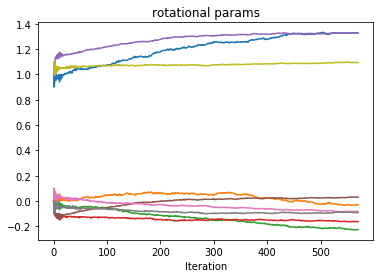

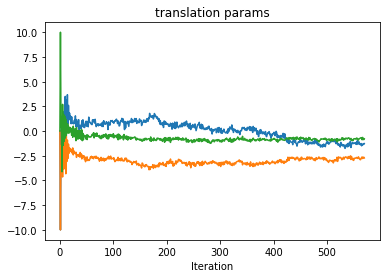

In [24]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.365724515113 -0.383744044187
[[ 0.99797241  0.01061658 -0.03472884  1.82496925]
 [-0.11777261  1.14603653 -0.10943048 -1.69704698]
 [ 0.02082406 -0.04436038  1.04830059 -0.17313284]]


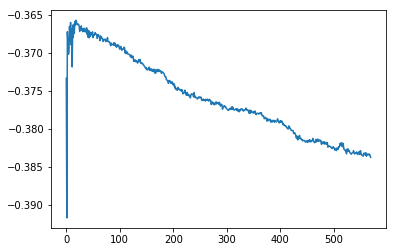

In [26]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [27]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [28]:
structure = '3N_L'

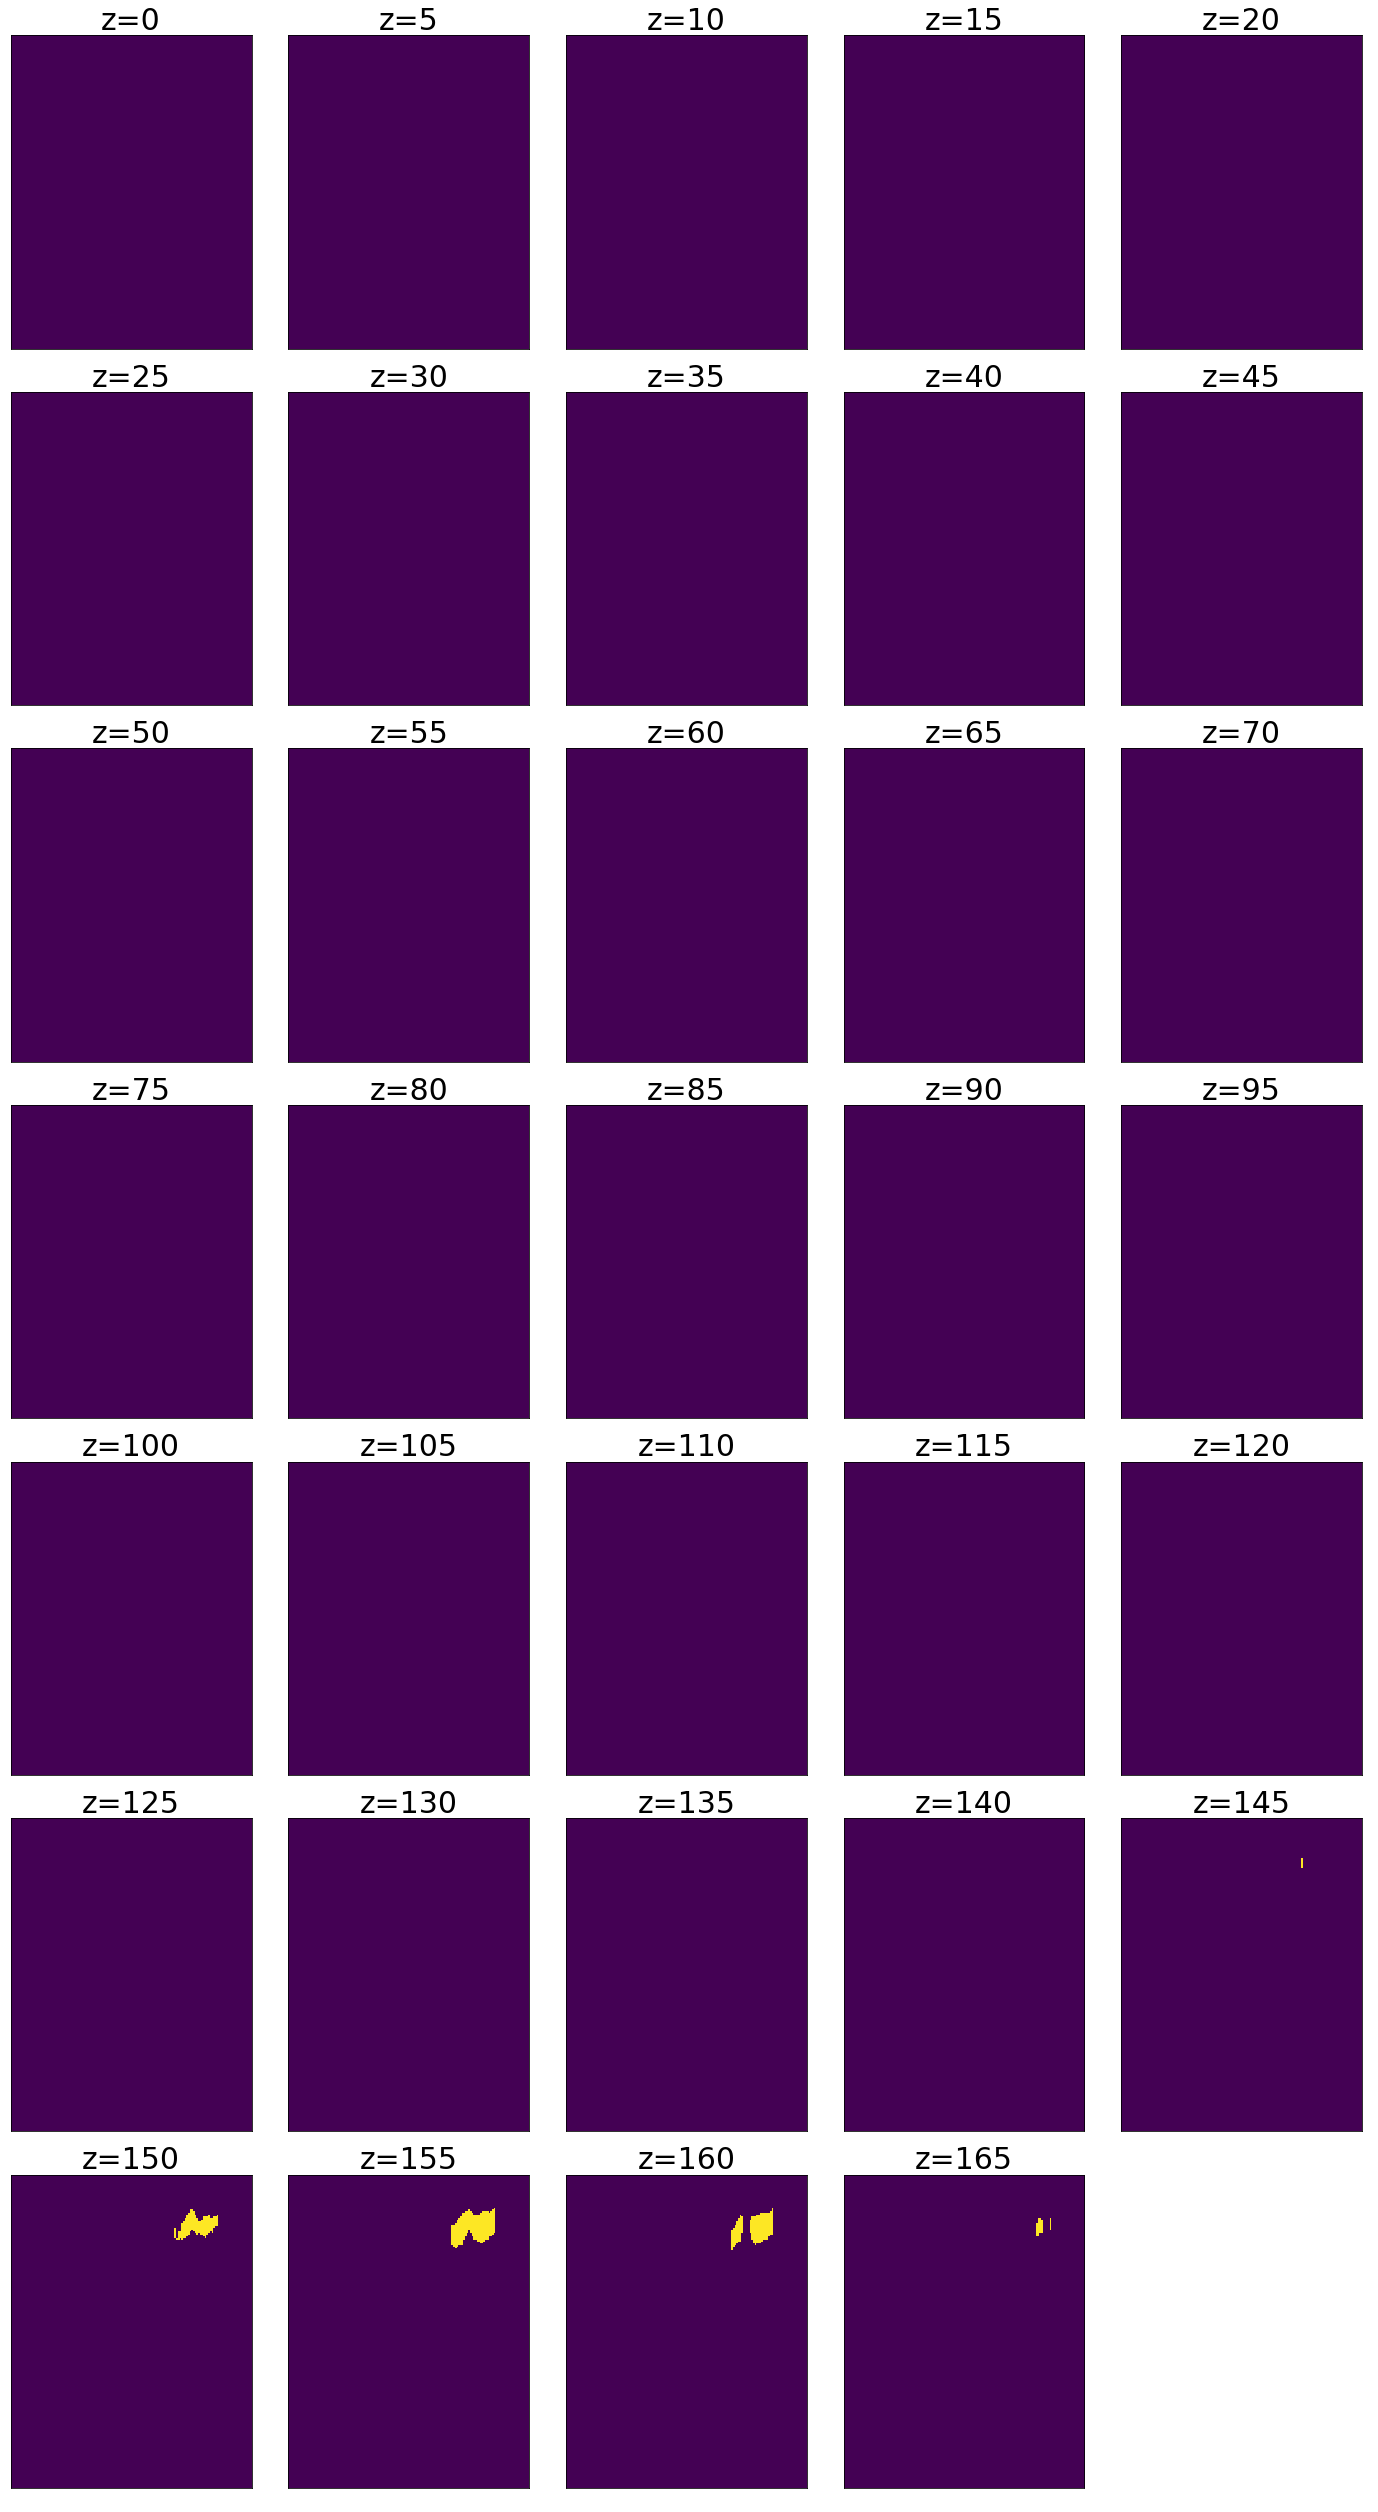

In [29]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [30]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

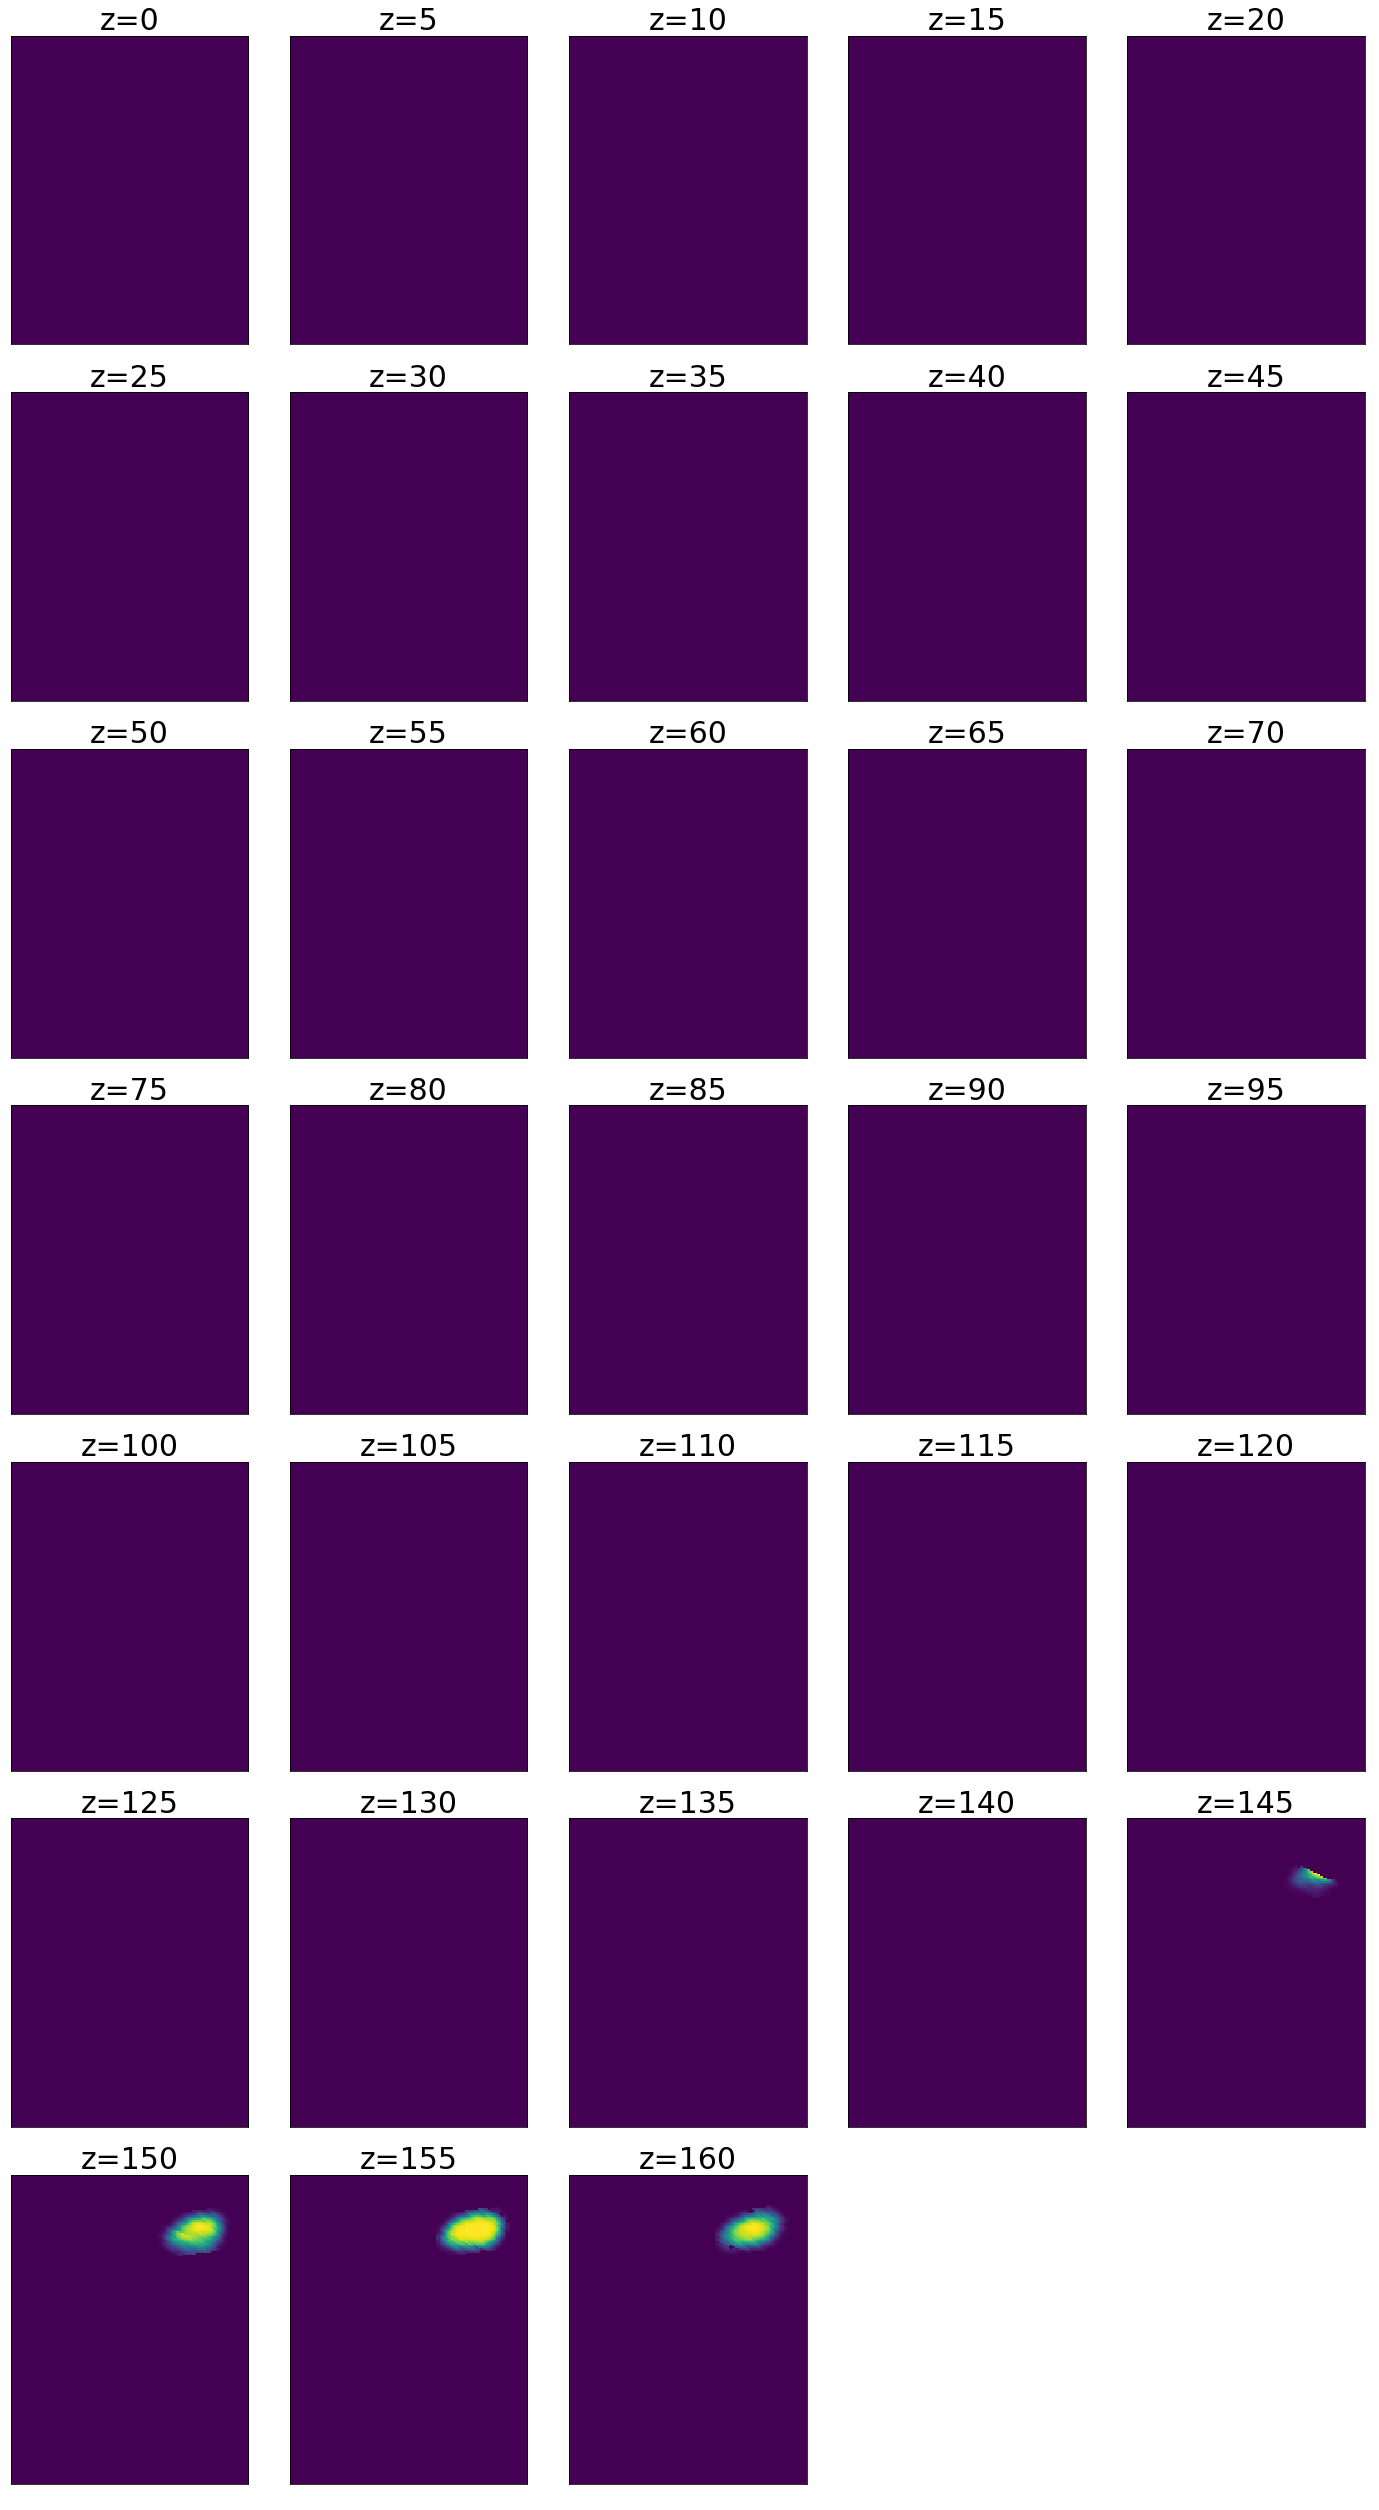

In [31]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)

In [32]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30new_down32_scoreVolume_scoreEvolution.png" "s3://mo

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [63]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [64]:
# stack_fixed = 'LM30new'
stack_fixed = 'LM40new'
# stack_fixed = 'LM30'
# stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [65]:
warp_setting = 22

In [66]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                        None
transform_type                                         rigid
terminate_thresh                                         NaN
grad_computation_sample_number                        100000
grid_search_sample_number                              10000
std_tx_um                                                200
std_ty_um                                                200
std_tz_um                                                200
std_theta_xy_degree                                       30
surround_weight                                      inverse
regularization_weight                                      0
comment                           global reg rigid with surr
max_iter_num                                             NaN
Name: 22, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [67]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [68]:
lr1 = 10
lr2 = 0.1

In [69]:
structure = 'SNR_L'

In [70]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (163, 113, 182)


In [71]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -19   93 1133 1295 5918 6099]


In [72]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)


In [73]:
label_weights_m

{1: 1.0, 2: 0.40870655618253604}

In [74]:
aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 55.11165633  97.61789349  62.03171572]


In [75]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [76]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [79]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.063736 seconds
load gradient 2: 0.065711 seconds
overall: 0.129571 seconds


In [80]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
step: 0.25 seconds
current score: 0.222423
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
step: 0.24 seconds
current score: 0.223749
new_T: [ 1.36760808 -0.59689     0.01274399]
det: 1.00

iteration 2
step: 0.24 seconds
current score: 0.224014
new_T: [ 0.94010117 -1.38053902  0.04385762]
det: 1.00

iteration 3
step: 0.24 seconds
current score: 0.225569
new_T: [ 1.27264981 -1.3294489  -0.31655988]
det: 1.00

iteration 4
step: 0.24 seconds
current score: 0.226181
new_T: [ 1.27269428 -1.58495496 -0.34799457]
det: 1.00

iteration 5
step: 0.24 seconds
current score: 0.226255
new_T: [ 1.42494315 -1.58323812 -0.53271219]
det: 1.00

iteration 6
step: 0.24 seconds
current score: 0.226711
new_T: [ 1.37282612 -1.70671172 -0.56647125]
det: 1.00

iteration 7
step: 0.24 seconds
current score: 0.227201
new_T: [ 1.45983989 -1.73845746 -0.6174907 ]
det: 1.00

iteration 8
step: 0.24 seconds
current score: 0.227562
new_T: [ 1.45719836 -1.77340099 -0.62341331]
det: 1.00



step: 0.24 seconds
current score: 0.234720
new_T: [ 1.3938494  -0.70810851  0.45493499]
det: 1.00

iteration 74
step: 0.24 seconds
current score: 0.234770
new_T: [ 1.36655028 -0.72193428  0.46747611]
det: 1.00

iteration 75
step: 0.24 seconds
current score: 0.234809
new_T: [ 1.37786452 -0.70803918  0.46471169]
det: 1.00

iteration 76
step: 0.24 seconds
current score: 0.234865
new_T: [ 1.37128587 -0.71908232  0.47682875]
det: 1.00

iteration 77
step: 0.24 seconds
current score: 0.234899
new_T: [ 1.38386907 -0.70333571  0.47030482]
det: 1.00

iteration 78
step: 0.24 seconds
current score: 0.234941
new_T: [ 1.37000088 -0.70468573  0.46869512]
det: 1.00

iteration 79
step: 0.24 seconds
current score: 0.234993
new_T: [ 1.37889483 -0.70003017  0.47295652]
det: 1.00

iteration 80
step: 0.24 seconds
current score: 0.235027
new_T: [ 1.36716893 -0.70552041  0.47326617]
det: 1.00

iteration 81
step: 0.24 seconds
current score: 0.235060
new_T: [ 1.37075391 -0.69493809  0.47277394]
det: 1.00

itera

step: 0.24 seconds
current score: 0.236737
new_T: [ 1.30487694 -0.66914999  0.62150866]
det: 1.00

iteration 147
step: 0.24 seconds
current score: 0.236744
new_T: [ 1.29553628 -0.65103432  0.61753281]
det: 1.00

iteration 148
step: 0.24 seconds
current score: 0.236750
new_T: [ 1.30040049 -0.66073529  0.63612589]
det: 1.00

iteration 149
step: 0.24 seconds
current score: 0.236785
new_T: [ 1.28601827 -0.65207972  0.63075252]
det: 1.00

iteration 150
step: 0.24 seconds
current score: 0.236795
new_T: [ 1.29758902 -0.65216016  0.6338971 ]
det: 1.00

iteration 151
step: 0.24 seconds
current score: 0.236809
new_T: [ 1.29596173 -0.65682067  0.64540445]
det: 1.00

iteration 152
step: 0.24 seconds
current score: 0.236825
new_T: [ 1.28201663 -0.65488316  0.64304434]
det: 1.00

iteration 153
step: 0.24 seconds
current score: 0.236846
new_T: [ 1.29128321 -0.64736527  0.64199289]
det: 1.00

iteration 154
step: 0.24 seconds
current score: 0.236866
new_T: [ 1.27400585 -0.65063021  0.65390628]
det: 1.0

step: 0.24 seconds
current score: 0.237638
new_T: [ 1.24802518 -0.74572341  0.66556957]
det: 1.00

iteration 220
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24879427 -0.74817569  0.6685568 ]
det: 1.00

iteration 221
step: 0.24 seconds
current score: 0.237653
new_T: [ 1.25354169 -0.75127492  0.67140169]
det: 1.00

iteration 222
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24760929 -0.7529262   0.67310992]
det: 1.00

iteration 223
step: 0.24 seconds
current score: 0.237662
new_T: [ 1.24839657 -0.75431684  0.67869684]
det: 1.00

iteration 224
step: 0.24 seconds
current score: 0.237673
new_T: [ 1.22822424 -0.75932203  0.67965289]
det: 1.00

iteration 225
step: 0.24 seconds
current score: 0.237668
new_T: [ 1.23679773 -0.73890327  0.68741007]
det: 1.00

iteration 226
step: 0.24 seconds
current score: 0.237683
new_T: [ 1.22237903 -0.74323461  0.69909527]
det: 1.00

iteration 227
step: 0.24 seconds
current score: 0.237703
new_T: [ 1.22907953 -0.74314714  0.70196638]
det: 1.0

step: 0.24 seconds
current score: 0.238153
new_T: [ 1.23050833 -0.82870152  0.71156273]
det: 1.00

iteration 293
step: 0.24 seconds
current score: 0.238155
new_T: [ 1.22865807 -0.83695827  0.71363325]
det: 1.00

iteration 294
step: 0.24 seconds
current score: 0.238152
new_T: [ 1.22972795 -0.83325337  0.70937309]
det: 1.00

iteration 295
step: 0.24 seconds
current score: 0.238157
new_T: [ 1.22501525 -0.83946984  0.7142254 ]
det: 1.00

iteration 296
step: 0.24 seconds
current score: 0.238160
new_T: [ 1.22921387 -0.83995957  0.71635829]
det: 1.00

iteration 297
step: 0.24 seconds
current score: 0.238172
new_T: [ 1.22081589 -0.83043317  0.71182109]
det: 1.00

iteration 298
step: 0.24 seconds
current score: 0.238181
new_T: [ 1.22141874 -0.83820047  0.72242524]
det: 1.00

iteration 299
step: 0.24 seconds
current score: 0.238182
new_T: [ 1.22658974 -0.82688579  0.7176372 ]
det: 1.00

iteration 300
step: 0.24 seconds
current score: 0.238188
new_T: [ 1.21305502 -0.82544113  0.72053833]
det: 1.0

step: 0.24 seconds
current score: 0.238451
new_T: [ 1.2104856  -0.9305204   0.67179492]
det: 1.00

iteration 366
step: 0.24 seconds
current score: 0.238448
new_T: [ 1.22226972 -0.93633408  0.68006281]
det: 1.00

iteration 367
step: 0.24 seconds
current score: 0.238469
new_T: [ 1.2214833  -0.92668787  0.67498692]
det: 1.00

iteration 368
step: 0.24 seconds
current score: 0.238457
new_T: [ 1.20404315 -0.93122167  0.67899679]
det: 1.00

iteration 369
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.23802508 -0.93767862  0.68154885]
det: 1.00

iteration 370
step: 0.24 seconds
current score: 0.238483
new_T: [ 1.21173374 -0.92629998  0.66898777]
det: 1.00

iteration 371
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.21366344 -0.94592462  0.68640514]
det: 1.00

iteration 372
step: 0.24 seconds
current score: 0.238476
new_T: [ 1.23202118 -0.92303649  0.67242383]
det: 1.00

iteration 373
step: 0.24 seconds
current score: 0.238487
new_T: [ 1.19196497 -0.94105787  0.68119055]
det: 1.0

step: 0.24 seconds
current score: 0.238560
new_T: [ 1.23759028 -0.98033934  0.7022584 ]
det: 1.00

iteration 439
step: 0.25 seconds
current score: 0.238559
new_T: [ 1.23801979 -0.97755592  0.69805635]
det: 1.00

iteration 440
step: 0.24 seconds
current score: 0.238561
new_T: [ 1.23468953 -0.98550202  0.70774335]
det: 1.00

iteration 441
step: 0.24 seconds
current score: 0.238564
new_T: [ 1.24055929 -0.98356226  0.70683774]
det: 1.00

iteration 442
step: 0.24 seconds
current score: 0.238569
new_T: [ 1.23973359 -0.98174201  0.71147691]
det: 1.00

iteration 443
step: 0.24 seconds
current score: 0.238577
new_T: [ 1.24061849 -0.9813054   0.7100714 ]
det: 1.00

iteration 444
step: 0.24 seconds
current score: 0.238575
new_T: [ 1.23720721 -0.98192275  0.71210679]
det: 1.00

iteration 445
step: 0.24 seconds
current score: 0.238572
new_T: [ 1.24597461 -0.98111051  0.71746183]
det: 1.00

iteration 446
step: 0.24 seconds
current score: 0.238576
new_T: [ 1.23074625 -0.97847917  0.71008176]
det: 1.0

step: 0.24 seconds
current score: 0.238673
new_T: [ 1.21612693 -1.00901153  0.73677893]
det: 1.00

iteration 512
step: 0.24 seconds
current score: 0.238678
new_T: [ 1.22021458 -1.00750167  0.73654666]
det: 1.00

iteration 513
step: 0.24 seconds
current score: 0.238672
new_T: [ 1.21711055 -1.00871568  0.73806939]
det: 1.00

iteration 514
step: 0.24 seconds
current score: 0.238677
new_T: [ 1.21884465 -1.00405894  0.73681908]
det: 1.00

iteration 515
step: 0.24 seconds
current score: 0.238679
new_T: [ 1.21466208 -1.00773811  0.73938754]
det: 1.00

iteration 516
step: 0.24 seconds
current score: 0.238687
new_T: [ 1.21743883 -1.00420858  0.73336215]
det: 1.00

iteration 517
step: 0.24 seconds
current score: 0.238685
new_T: [ 1.21640858 -1.01508611  0.73732567]
det: 1.00

iteration 518
step: 0.24 seconds
current score: 0.238690
new_T: [ 1.21471013 -1.00992186  0.72904909]
det: 1.00

iteration 519
step: 0.24 seconds
current score: 0.238691
new_T: [ 1.21769902 -1.01843784  0.73432641]
det: 1.0

step: 0.24 seconds
current score: 0.238723
new_T: [ 1.20769924 -1.04054373  0.74419903]
det: 1.00

iteration 585
step: 0.24 seconds
current score: 0.238720
new_T: [ 1.19952939 -1.04908449  0.75303621]
det: 1.00

iteration 586
step: 0.24 seconds
current score: 0.238727
new_T: [ 1.21392891 -1.03989975  0.75186816]
det: 1.00

iteration 587
step: 0.24 seconds
current score: 0.238717
new_T: [ 1.20373549 -1.0500581   0.76196339]
det: 1.00

iteration 588
step: 0.24 seconds
current score: 0.238719
new_T: [ 1.21023864 -1.03948762  0.7573311 ]
det: 1.00

iteration 589
step: 0.24 seconds
current score: 0.238712
new_T: [ 1.20669869 -1.04269644  0.76563671]
det: 1.00

iteration 590
step: 0.24 seconds
current score: 0.238715
new_T: [ 1.21198956 -1.0369413   0.7593696 ]
det: 1.00

iteration 591
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20449929 -1.04243524  0.76402902]
det: 1.00

iteration 592
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20317675 -1.03796738  0.76590389]
det: 1.0

step: 0.24 seconds
current score: 0.238743
new_T: [ 1.20636765 -1.065951    0.76447118]
det: 1.00

iteration 658
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19972379 -1.06427685  0.7674464 ]
det: 1.00

iteration 659
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.20308106 -1.06180593  0.76638252]
det: 1.00

iteration 660
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.19929743 -1.06187513  0.76790194]
det: 1.00

iteration 661
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.201477   -1.06169688  0.76814908]
det: 1.00

iteration 662
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.2022052  -1.06533885  0.77203337]
det: 1.00

iteration 663
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.2025305  -1.06073588  0.77025376]
det: 1.00

iteration 664
step: 0.24 seconds
current score: 0.238764
new_T: [ 1.20287199 -1.06207636  0.77458862]
det: 1.00

iteration 665
step: 0.24 seconds
current score: 0.238765
new_T: [ 1.20422193 -1.05499562  0.77534024]
det: 1.0

step: 0.24 seconds
current score: 0.238779
new_T: [ 1.17649819 -1.06428594  0.79619494]
det: 1.00

iteration 731
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.18603267 -1.04830673  0.78922936]
det: 1.00

iteration 732
step: 0.24 seconds
current score: 0.238774
new_T: [ 1.17911192 -1.064759    0.79816269]
det: 1.00

iteration 733
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.185044   -1.05105307  0.78659686]
det: 1.00

iteration 734
step: 0.24 seconds
current score: 0.238768
new_T: [ 1.18307164 -1.0668407   0.80096128]
det: 1.00

iteration 735
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.18245978 -1.05560423  0.78487306]
det: 1.00

iteration 736
step: 0.24 seconds
current score: 0.238767
new_T: [ 1.17152504 -1.06575029  0.79421014]
det: 1.00

iteration 737
step: 0.24 seconds
current score: 0.238777
new_T: [ 1.19127234 -1.04715016  0.78142272]
det: 1.00

iteration 738
step: 0.24 seconds
current score: 0.238773
new_T: [ 1.17865446 -1.06563686  0.80157366]
det: 1.0

step: 0.24 seconds
current score: 0.238748
new_T: [ 1.1947163  -1.10813121  0.78689514]
det: 1.00

iteration 804
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20262913 -1.11005325  0.78985042]
det: 1.00

iteration 805
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19812614 -1.11119522  0.78290076]
det: 1.00

iteration 806
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.20372181 -1.11623422  0.78267053]
det: 1.00

iteration 807
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19852147 -1.11620342  0.77289888]
det: 1.00

iteration 808
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20301991 -1.11526232  0.76732868]
det: 1.00

iteration 809
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19484007 -1.11656291  0.76906867]
det: 1.00

iteration 810
step: 0.24 seconds
current score: 0.238739
new_T: [ 1.20226584 -1.1185126   0.77303879]
det: 1.00

iteration 811
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20429977 -1.11603758  0.76680347]
det: 1.0

step: 0.24 seconds
current score: 0.238757
new_T: [ 1.20361112 -1.1075198   0.80489668]
det: 1.00

iteration 877
step: 0.24 seconds
current score: 0.238759
new_T: [ 1.20393265 -1.10929728  0.80398046]
det: 1.00

iteration 878
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20456755 -1.10976582  0.80509601]
det: 1.00

iteration 879
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20361019 -1.10722924  0.80322614]
det: 1.00

iteration 880
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20238178 -1.10689008  0.80323306]
det: 1.00

iteration 881
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20087635 -1.10604012  0.80391648]
det: 1.00

iteration 882
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20050692 -1.10846801  0.80244635]
det: 1.00

iteration 883
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20215781 -1.10756131  0.80310438]
det: 1.00

iteration 884
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20221477 -1.10654041  0.80313694]
det: 1.0

step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19225326 -1.11710658  0.76127307]
det: 1.00

iteration 950
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19245863 -1.1204119   0.76405992]
det: 1.00

iteration 951
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19373039 -1.11990713  0.76141511]
det: 1.00

iteration 952
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.19034811 -1.12056146  0.7622228 ]
det: 1.00

iteration 953
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19068156 -1.12142641  0.76254604]
det: 1.00

iteration 954
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.18988265 -1.12315723  0.76244846]
det: 1.00

iteration 955
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19291854 -1.12208348  0.75791988]
det: 1.00

iteration 956
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.18903953 -1.12796441  0.76563135]
det: 1.00

iteration 957
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.19385318 -1.11872173  0.75580458]
det: 1.0

step: 0.24 seconds
current score: 0.238734
new_T: [ 1.21263662 -1.16943572  0.71355974]
det: 1.00

iteration 1023
step: 0.24 seconds
current score: 0.238740
new_T: [ 1.20380452 -1.17392593  0.71690749]
det: 1.00

iteration 1024
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.21511489 -1.17616859  0.71463442]
det: 1.00

iteration 1025
step: 0.24 seconds
current score: 0.238756
new_T: [ 1.21393947 -1.17141757  0.710802  ]
det: 1.00

iteration 1026
step: 0.24 seconds
current score: 0.238748
new_T: [ 1.20045006 -1.17436127  0.71668647]
det: 1.00

iteration 1027
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21782306 -1.17418143  0.71098652]
det: 1.00

iteration 1028
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.20326803 -1.17259147  0.71881312]
det: 1.00

iteration 1029
step: 0.24 seconds
current score: 0.238744
new_T: [ 1.22003197 -1.17448759  0.71600075]
det: 1.00

iteration 1030
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20625136 -1.17349937  0.71892961]


step: 0.24 seconds
current score: 0.238749
new_T: [ 1.20864487 -1.15938541  0.7445651 ]
det: 1.00

iteration 1095
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21256482 -1.16310711  0.7458795 ]
det: 1.00

iteration 1096
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20821238 -1.15791213  0.74891353]
det: 1.00

iteration 1097
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.21156689 -1.15823725  0.74740551]
det: 1.00

iteration 1098
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20520684 -1.16220906  0.75316948]
det: 1.00

iteration 1099
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21217647 -1.16381656  0.7435146 ]
det: 1.00

iteration 1100
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21133184 -1.15823576  0.74514106]
det: 1.00

iteration 1101
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20967174 -1.15997471  0.75149667]
det: 1.00

iteration 1102
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20802203 -1.16189958  0.75090366]


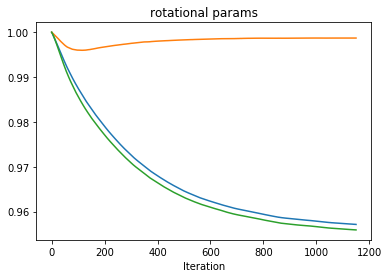

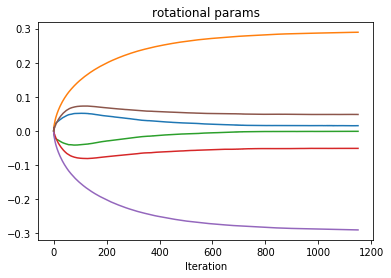

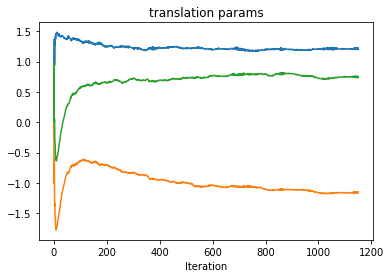

In [81]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.238797293652 0.23876098375
[[ 0.95988987  0.01599257  0.27992085  1.16990232]
 [-0.00155297  0.99865987 -0.05173056 -1.07183643]
 [-0.28037302  0.04922093  0.95862833  0.79604026]]


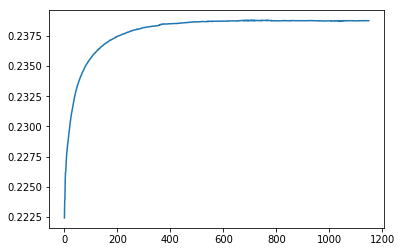

In [82]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

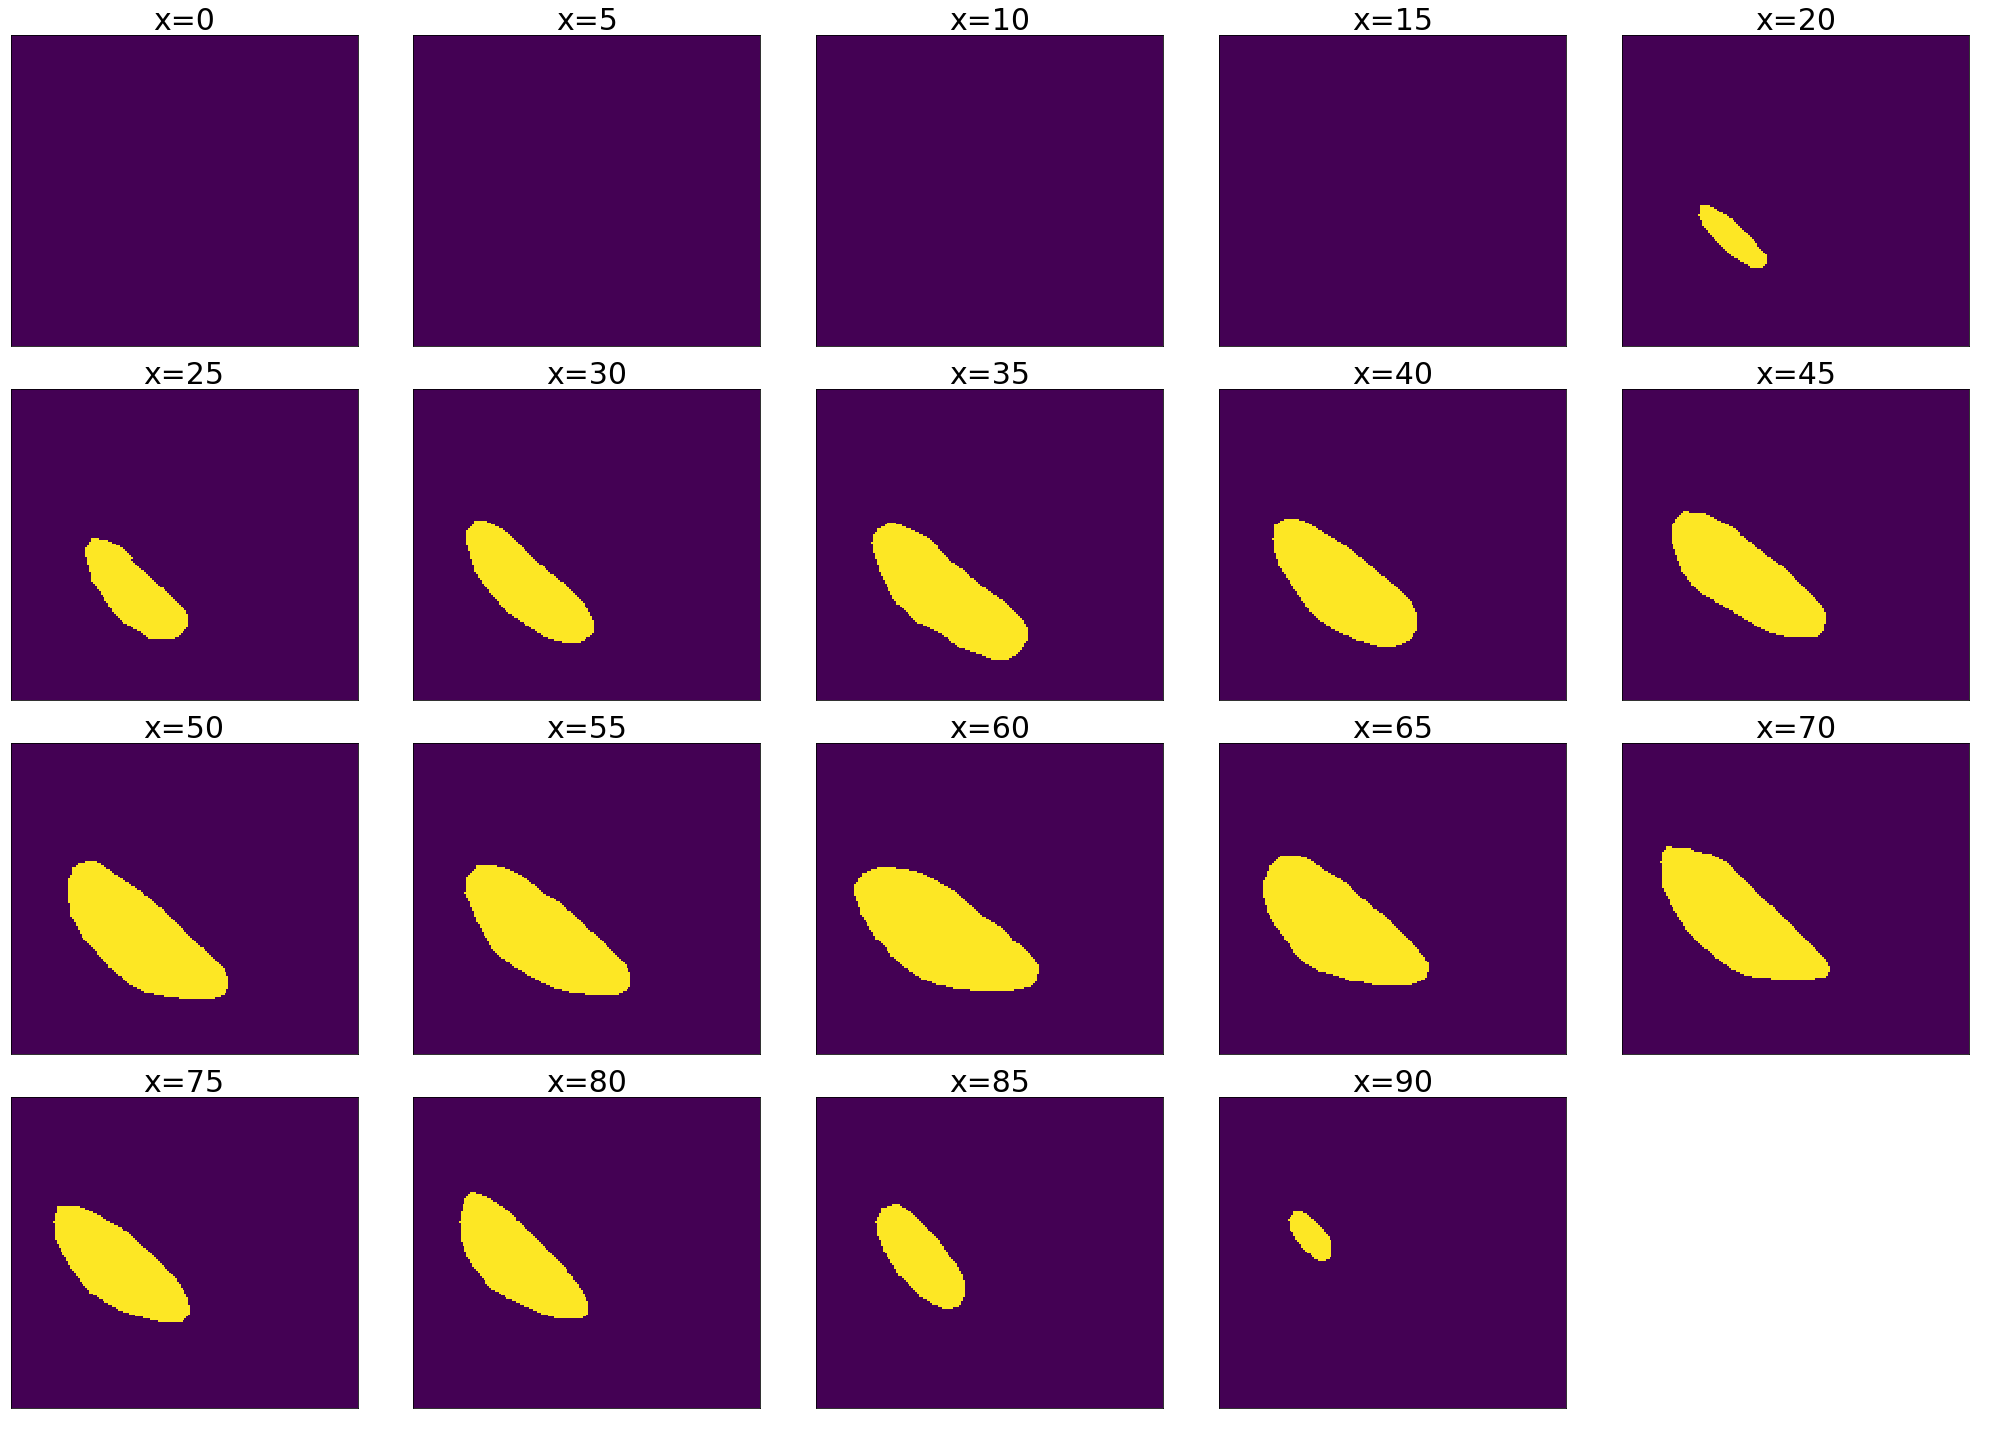

In [83]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [84]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(aligner.Ts[-1], 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [88]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

In [89]:
x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

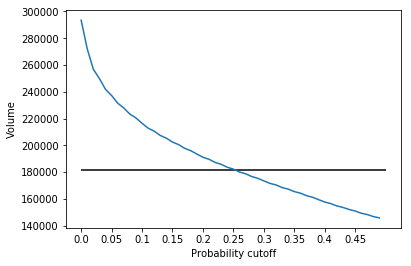

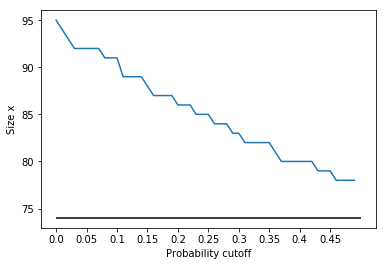

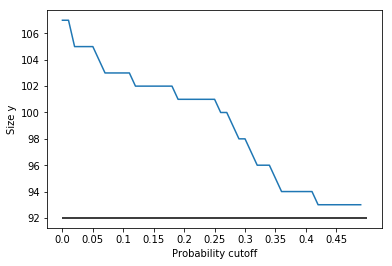

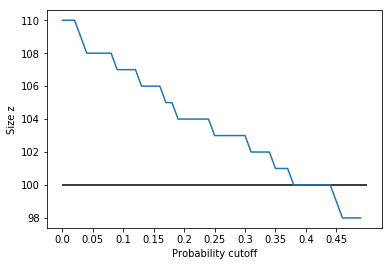

In [90]:
plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Volume');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size x');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size y');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size z');
plt.show();

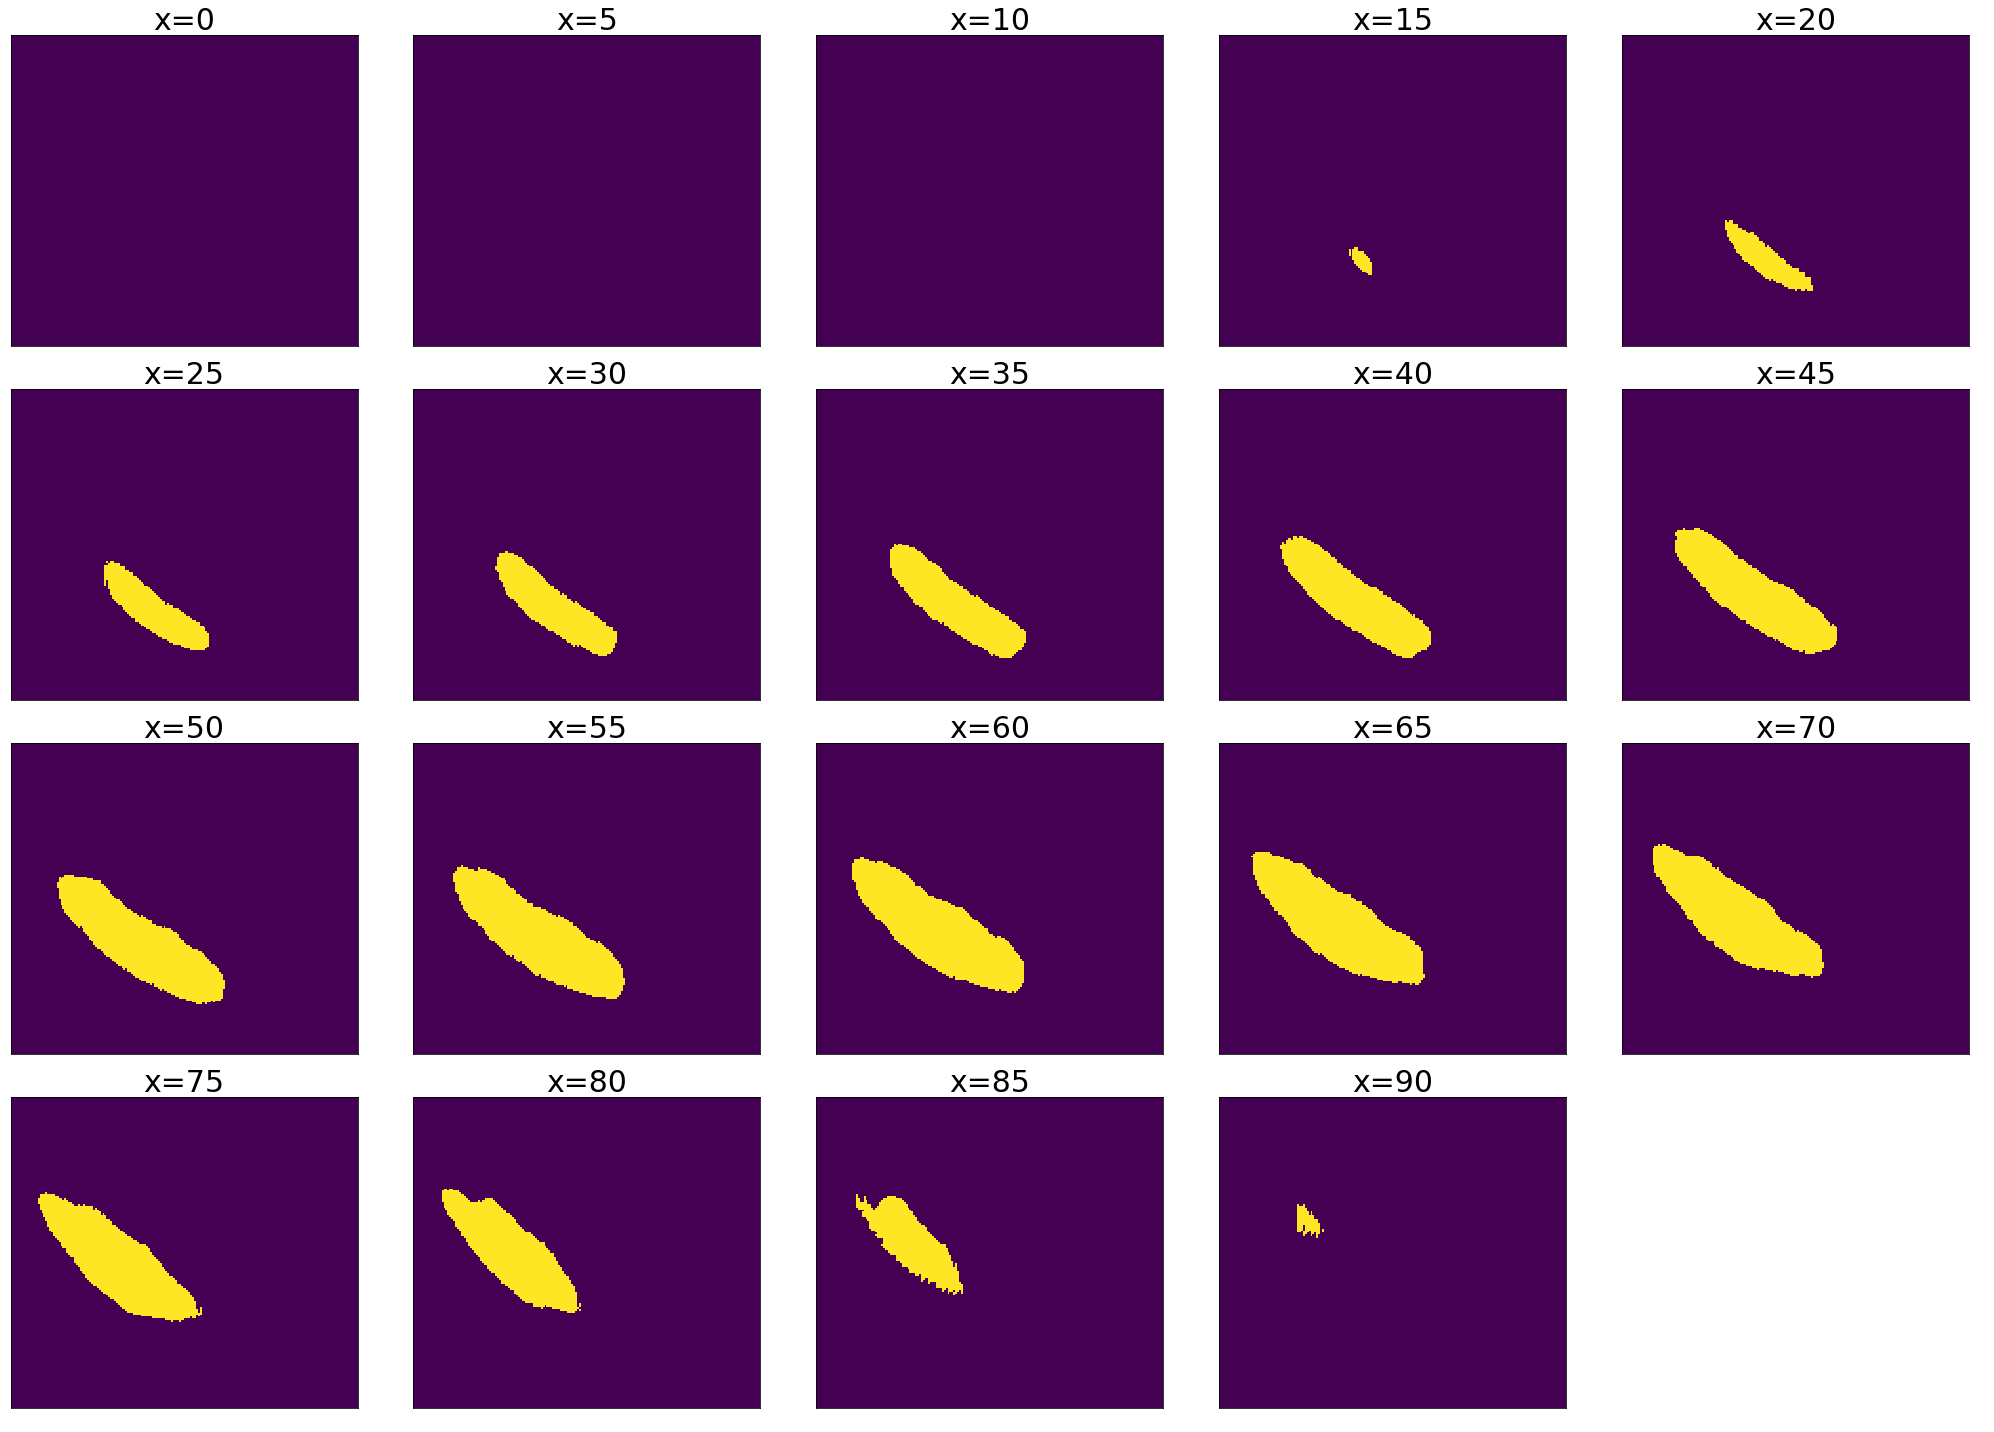

In [91]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f > 0.5, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [92]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32